In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import json

import torchvision
import torch

from pathlib import Path
from PIL import Image
from pprint import pprint
from tqdm import tqdm

from torch import nn, optim
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler

# custom imports
from etnicity_ai import data, resnet_model, utils, metrics, train

# launch tensorboard writer
writer = SummaryWriter('../runs/fairface/')

utils.set_random_seed(42)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
train_files = train_label['file'].tolist()

val_label = pd.read_csv('../data/fairface_label_val.csv')
val_files = val_label['file'].tolist()

dataset_files = None

if not os.path.exists("../data/dataset.json"):

    train_files_random = train_label['file'].tolist()
    np.random.shuffle(train_files_random)

    split_idx = int(len(train_files_random) * 0.8)
    train_set, test_set = train_files_random[:split_idx], train_files_random[split_idx:]

    dataset_files = {
        'train': train_set,
        'test': test_set,
        'val': val_files
    }
    
    with open("../data/dataset.json", "w") as file:
        json.dump(dataset_files, file)
else:
    with open("../data/dataset.json", "r") as file:
        dataset_files = json.load(file)

resnet = resnet50(weights='IMAGENET1K_V1')

In [12]:
race_dict = {
    'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0
}
encoders = {'race' : race_dict}

In [16]:
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [17]:
train_label.drop(['gender', 'age', 'service_test'], axis=1)

,file,race
0,train/1.jpg,East Asian
1,train/2.jpg,Indian
2,train/3.jpg,Black
3,train/4.jpg,Indian
4,train/5.jpg,Indian
...,...,...
86739,train/86740.jpg,Indian
86740,train/86741.jpg,Indian
86741,train/86742.jpg,Indian
86742,train/86743.jpg,Black


In [27]:
root_dir = Path('..')
images_dir = 'data/images/'

batch_size = 128

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.RandomPerspective(p=0.5),
                                                                      transforms.RandomGrayscale(p=0.2),
                                                                      transforms.RandomAdjustSharpness(2, p=0.5),
                                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                           std=[0.229, 0.224, 0.225])
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, shuffle=True, num_workers=8)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, shuffle=True, num_workers=8)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                        std=[0.229, 0.224, 0.225])]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


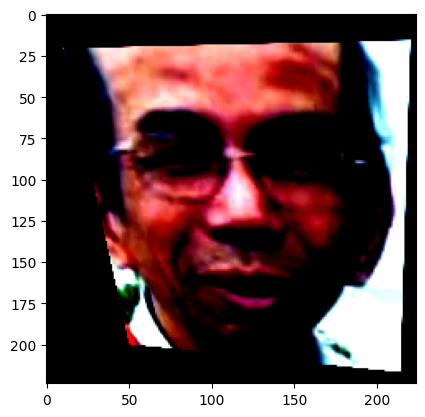

In [28]:
def display_torch_img(dataset, index):
    """Displays a single image from the given dataset at the given index.

    Args:
        dataset: A PyTorch dataset object or the array of tensors.
        index: The index of the image to display.

    Returns:
        None.
    """

    # Check if the dataset is a FairFaceDataset object.
    if type(dataset) == data.FairFaceDataset:

        # Get the image from the dataset.
        img = dataset[index]['image']

        # If the image is a 4D tensor, squeeze it to a 3D tensor.
        if len(dataset[index]['image'].shape) == 4:
            img = torch.squeeze(img)

    # Otherwise, the dataset is assumed to be an array of tensors.
    else:

        # Get the image from the dataset.
        img = dataset[index]

    # Permute the image axes so that the channel axis is the last axis.
    img = img.permute(1, 2, 0)

    # Display the image using Matplotlib.
    plt.imshow(img)
    plt.show()

display_torch_img(fairface_train, 8)

In [29]:
img_grid = torchvision.utils.make_grid(fairface_train[13]['image'])
writer.add_image('fairface_image1', img_grid)

img_grid = torchvision.utils.make_grid(fairface_train[26]['image'])
writer.add_image('fairface_image2', img_grid)

for i in range(5):
    img_grid = torchvision.utils.make_grid(fairface_train[14 + i]['image'])
    writer.add_image(f'fairface_image{i + 3}', img_grid)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
model = resnet_model.FairFaceResNet(resnet).to(device)

# For race and age classes
bce = nn.BCELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


In [ ]:
# map ages
mappings = {'race_map' : utils.get_mappings(race_dict)}

class_dicts = {'race' : race_dict}
# train the model
best_model = train.train_model(model, criterion, 
                               optimizer, scheduler_lr=scheduler, 
                               device=device, loaders=[train_loader, test_loader],
                               tensor_writer=writer, mappings=mappings, class_dicts=class_dicts, n_epochs=32)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:32<00:00, 16.31s/it]


Training step:
Epoch = 1, Loss = 1.970808744430542
Race accuracy = 0.21875	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.50s/it]


Validation step:
Epoch = 1, Loss = 1.9336770176887512
Race accuracy = 0.15625	
End of Epoch: 1 	Training Loss: 1.970808744430542 	Validation Loss: 1.9336770176887512
Validation loss decreased (inf --> 1.9336770176887512).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.18s/it]


Training step:
Epoch = 2, Loss = 1.964167833328247
Race accuracy = 0.09375	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.23s/it]


Validation step:
Epoch = 2, Loss = 1.9336713552474976
Race accuracy = 0.15625	
End of Epoch: 2 	Training Loss: 1.964167833328247 	Validation Loss: 1.9336713552474976
Validation loss decreased (1.9336770176887512 --> 1.9336713552474976).  Saving model ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.69s/it]


Training step:
Epoch = 3, Loss = 1.9620373249053955
Race accuracy = 0.21875	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.14s/it]


Validation step:
Epoch = 3, Loss = 1.9337040185928345
Race accuracy = 0.125	
End of Epoch: 3 	Training Loss: 1.9620373249053955 	Validation Loss: 1.9337040185928345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.99s/it]


Training step:
Epoch = 4, Loss = 1.9600481986999512
Race accuracy = 0.09375	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.84s/it]


Validation step:
Epoch = 4, Loss = 1.9338603615760803
Race accuracy = 0.125	
End of Epoch: 4 	Training Loss: 1.9600481986999512 	Validation Loss: 1.9338603615760803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.20s/it]


Training step:
Epoch = 5, Loss = 1.9655301570892334
Race accuracy = 0.09375	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.48s/it]


Validation step:
Epoch = 5, Loss = 1.93401437997818
Race accuracy = 0.125	
End of Epoch: 5 	Training Loss: 1.9655301570892334 	Validation Loss: 1.93401437997818


  0%|                                                                                                                | 0/2 [00:00<?, ?it/s]

In [ ]:
best_dir = Path('fix_when_model.pt')
model, optimizer, epoch = utils.load_ckp(best_dir, model, optimizer)
model = model.to(device)

In [ ]:
mappings = {'race_map' : utils.get_mappings(race_dict)}

races = metrics.build_confusion_matrix(model, val_loader, mappings, device=device)

In [ ]:
metrics.calc_measures(model, val_loader, device)

In [ ]:
def get_mismatched_classes(model, loader, true_cat, pred_cat, dictionary, output_class, device):
    """Gets the mismatched images for the given model, loader, true category, predicted category, dictionary, output class, and device.

    Args:
        model: The model to evaluate.
        loader: The loader to use to load the data.
        true_cat: The true category.
        pred_cat: The predicted category.
        dictionary: A dictionary mapping category names to indices.
        output_class: The output class.
        device: The device to use.

    Returns:
        A list of mismatched images.
    """
    # Initialize a list to store the mismatched images.
    mismatched_img = []
    # Set the model to evaluation mode.
    model.eval()
    # Iterate over the loader.
    with torch.no_grad():   
          
        for batch in tqdm(loader):
            # Move the images and labels to the device.
            image = batch['image'].to(device)
            age = batch[output_class].to(device)
            # Make a prediction.
            output = model(image)

            # Get the predicted class.
            _, predicted = torch.max(torch.softmax(output[f'{output_class}_pred'].data, dim=1), 1)
            # Iterate over the true and predicted classes.
            for true, pred, img in zip(age, predicted, image):
                # If the true and predicted categories are not the same, add the image to the list of mismatched images.
                if dictionary[true_cat] == int(true) and dictionary[pred_cat] == int(pred):
                    mismatched_img.append(img)
                    
    # Return the list of mismatched images.
    return mismatched_img

true_cat = 'Latino_Hispanic'
pred_cat = 'Middle Eastern'
mism_imgs = get_mismatched_classes(model, val_loader, true_cat, pred_cat, race_dict, 'race', device)
mism_imgs = [i.cpu() for i in mism_imgs]

In [ ]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

class Unnormalize(nn.Module):
    def __init__(self, mean, std):
        super(Unnormalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return self.unnormalize(x)

    def unnormalize(self, x):
        # Assuming x is a PyTorch tensor
        return x * self.std[None, :, None, None] + self.mean[None, :, None, None]

def show(imgs, true_cat, pred_cat):
    if not os.path.exists('../mismatched'):
        os.mkdir('../mismatched')
        
    img_batch = []
    cur_batch = 1
    if not isinstance(imgs, list):
        imgs = [imgs]
    for i, img in enumerate(tqdm(imgs)):
        img = np.array(img).transpose(1, 2, 0)
        img_batch.append(img)
        
        if (i + 1) % 20 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.title(f'True category = {true_cat}; Mismatched one = {pred_cat}')
            columns = 4
            rows = 5
            for i in range(1, columns*rows + 1):
                img = img_batch[i - 1]
                ax = fig.add_subplot(rows, columns, i)
                ax.set_axis_off()
                plt.imshow(img)
            fig.set_tight_layout(tight=True)
            fig.savefig(f'../mismatched/mismatched_age_number_{cur_batch}.png')
            plt.close()

            cur_batch += 1
            img_batch = []

# Example Usage:
mean = [0.485, 0.456, 0.406]  # Replace with your actual mean values
std = [0.229, 0.224, 0.225]   # Replace with your actual standard deviation values

# Create an instance of Unnormalize
unnormalize = Unnormalize(mean=mean, std=std)
show([unnormalize(i).squeeze(0) for i in mism_imgs], true_cat, pred_cat)